In [2]:
import numpy as np
import pandas as pd

from scipy import stats, odr

from statsmodels.stats.weightstats import ztest
import matplotlib.pyplot as plt
import seaborn as sns

# Input Data

In [3]:
# Drug tested M
dt_total_m = pd.read_pickle('DT_Total_M.pkl')
dt_bench_m = pd.read_pickle('DT_Bench_M.pkl')
dt_squat_m = pd.read_pickle('DT_Squat_M.pkl')
dt_dead_m = pd.read_pickle('DT_Dead_M.pkl') 

# Drug tested F
dt_total_f = pd.read_pickle('DT_Total_F.pkl')
dt_bench_f = pd.read_pickle('DT_Bench_F.pkl')
dt_squat_f = pd.read_pickle('DT_Squat_F.pkl')
dt_dead_f = pd.read_pickle('DT_Dead_F.pkl') 

# Non Drug tested M
ndt_total_m = pd.read_pickle('NDT_Total_M.pkl')
ndt_bench_m = pd.read_pickle('NDT_Bench_M.pkl')
ndt_squat_m = pd.read_pickle('NDT_Squat_M.pkl')
ndt_dead_m = pd.read_pickle('NDT_Dead_M.pkl') 

# Non Drug tested F
ndt_total_f = pd.read_pickle('NDT_Total_F.pkl')
ndt_bench_f = pd.read_pickle('NDT_Bench_F.pkl')
ndt_squat_f = pd.read_pickle('NDT_Squat_F.pkl')
ndt_dead_f = pd.read_pickle('NDT_Dead_F.pkl') 

# General Population M
gp_total_m = pd.read_pickle('GP_Total_M.pkl')
gp_bench_m = pd.read_pickle('GP_Bench_M.pkl')
gp_squat_m = pd.read_pickle('GP_Squat_M.pkl')
gp_dead_m = pd.read_pickle('GP_Dead_M.pkl') 

# General Population F
gp_total_f = pd.read_pickle('GP_Total_F.pkl')
gp_bench_f = pd.read_pickle('GP_Bench_F.pkl')
gp_squat_f = pd.read_pickle('GP_Squat_F.pkl')
gp_dead_f = pd.read_pickle('GP_Dead_F.pkl') 

# Visualizations

Peak Age for each Weight Group across the different populations.

In [4]:
def pop_label(df, label):
    df.loc[:,'Population'] = label
    return df

In [5]:
total = pd.concat([pop_label(dt_total_m,'Drug Tested'),pop_label(ndt_total_m,'Non Drug Tested'),
           pop_label(gp_total_m,'General Population'),
          pop_label(dt_total_f,'Drug Tested'),pop_label(ndt_total_f,'Non Drug Tested'),
           pop_label(gp_total_f,'General Population')],
          axis = 0, ignore_index = True)
bench = pd.concat([pop_label(dt_bench_m,'Drug Tested'),pop_label(ndt_bench_m,'Non Drug Tested'),
           pop_label(gp_bench_m,'General Population'),
          pop_label(dt_bench_f,'Drug Tested'),pop_label(ndt_bench_f,'Non Drug Tested'),
           pop_label(gp_bench_f,'General Population')],
          axis = 0, ignore_index = True)
squat = pd.concat([pop_label(dt_squat_m,'Drug Tested'),pop_label(ndt_squat_m,'Non Drug Tested'),
           pop_label(gp_squat_m,'General Population'),
          pop_label(dt_squat_f,'Drug Tested'),pop_label(ndt_squat_f,'Non Drug Tested'),
           pop_label(gp_squat_f,'General Population')],
          axis = 0, ignore_index = True)
dead = pd.concat([pop_label(dt_dead_m,'Drug Tested'),pop_label(ndt_dead_m,'Non Drug Tested'),
           pop_label(gp_dead_m,'General Population'),
          pop_label(dt_dead_f,'Drug Tested'),pop_label(ndt_dead_f,'Non Drug Tested'),
           pop_label(gp_dead_f,'General Population')],
          axis = 0, ignore_index = True)

In [6]:
def quad_plot_age(total, bench, squat, dead, sex):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))

    axs[0,0].set_title('Mean Age for Peak Total Weight Lifted for '+sex)
    axs[0,1].set_title('Mean Age for Peak Bench Press for '+sex)
    axs[1,0].set_title('Mean Age for Peak Squat for '+sex)
    axs[1,1].set_title('Mean Age for Peak Deadlift for '+sex)

    sns.barplot(total[total['Sex'] == sex].copy().groupby(['Weight','Population'])['Age'].mean().reset_index(),
                x = 'Weight', y = 'Age', hue = 'Population', ax = axs[0,0])
    sns.move_legend(axs[0,0], 'upper left', bbox_to_anchor=(1, 1))

    sns.barplot(bench[bench['Sex'] == sex].copy().groupby(['Weight','Population'])['Age'].mean().reset_index(),
                x = 'Weight', y = 'Age', hue = 'Population', ax = axs[0,1])
    sns.move_legend(axs[0,1], 'upper left', bbox_to_anchor=(1, 1))
    
    sns.barplot(squat[squat['Sex'] == sex].copy().groupby(['Weight','Population'])['Age'].mean().reset_index(),
                x = 'Weight', y = 'Age', hue = 'Population', ax = axs[1,0])
    sns.move_legend(axs[1,0], 'upper left', bbox_to_anchor=(1, 1))
    
    sns.barplot(dead[dead['Sex'] == sex].copy().groupby(['Weight','Population'])['Age'].mean().reset_index(),
                x = 'Weight', y = 'Age', hue = 'Population', ax = axs[1,1])
    sns.move_legend(axs[1,1], 'upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()

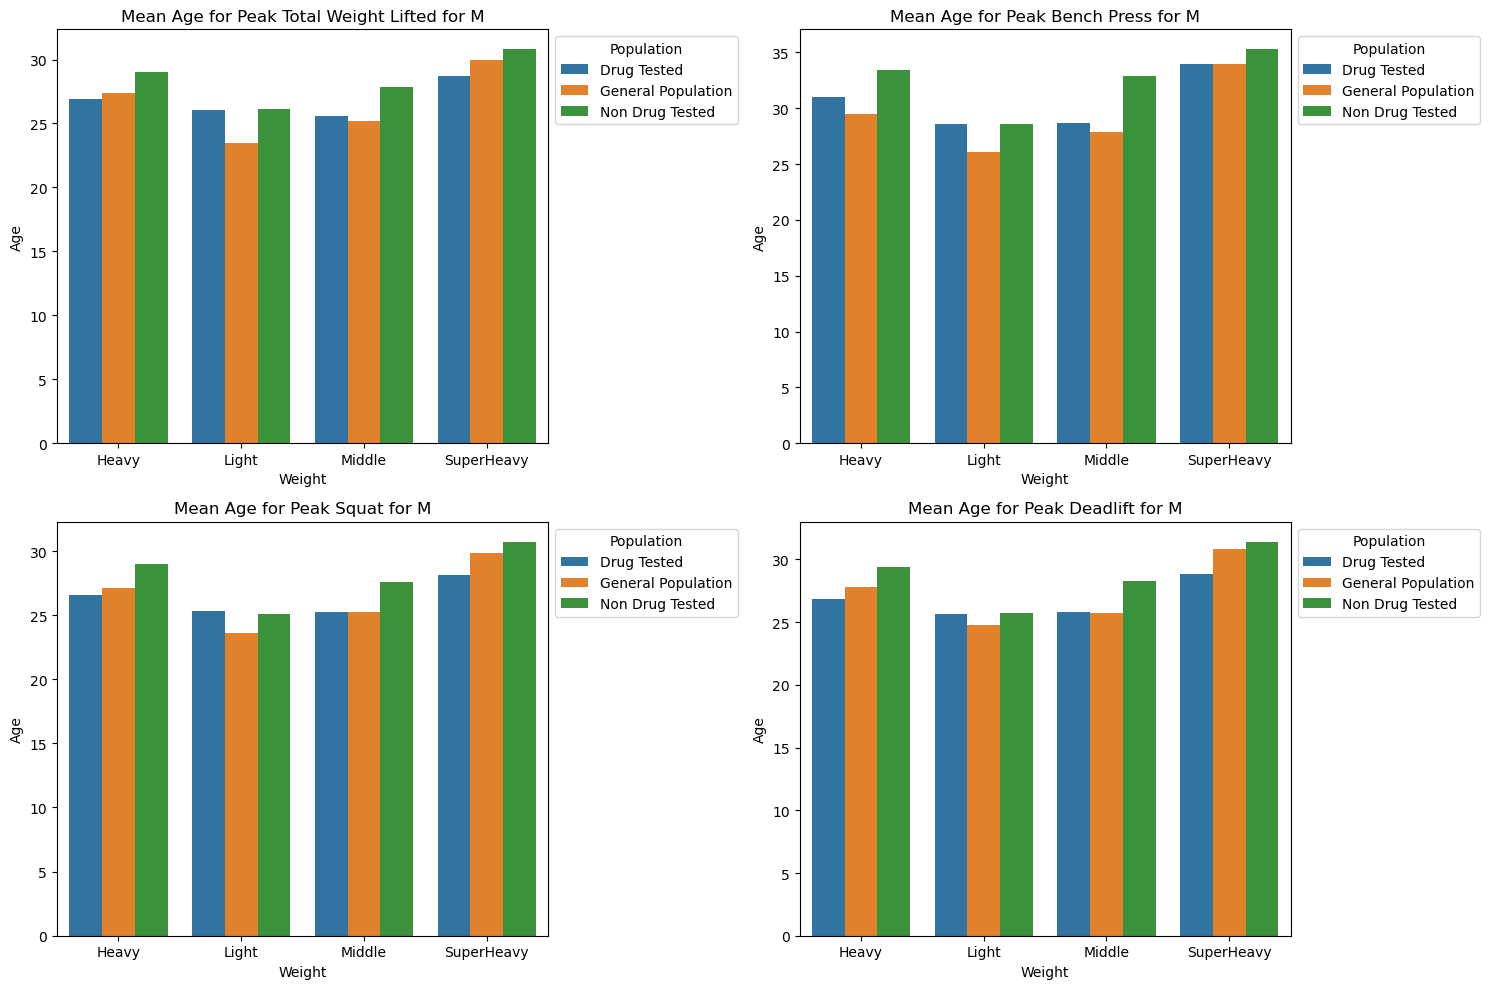

In [7]:
quad_plot_age(total, bench, squat, dead, 'M')

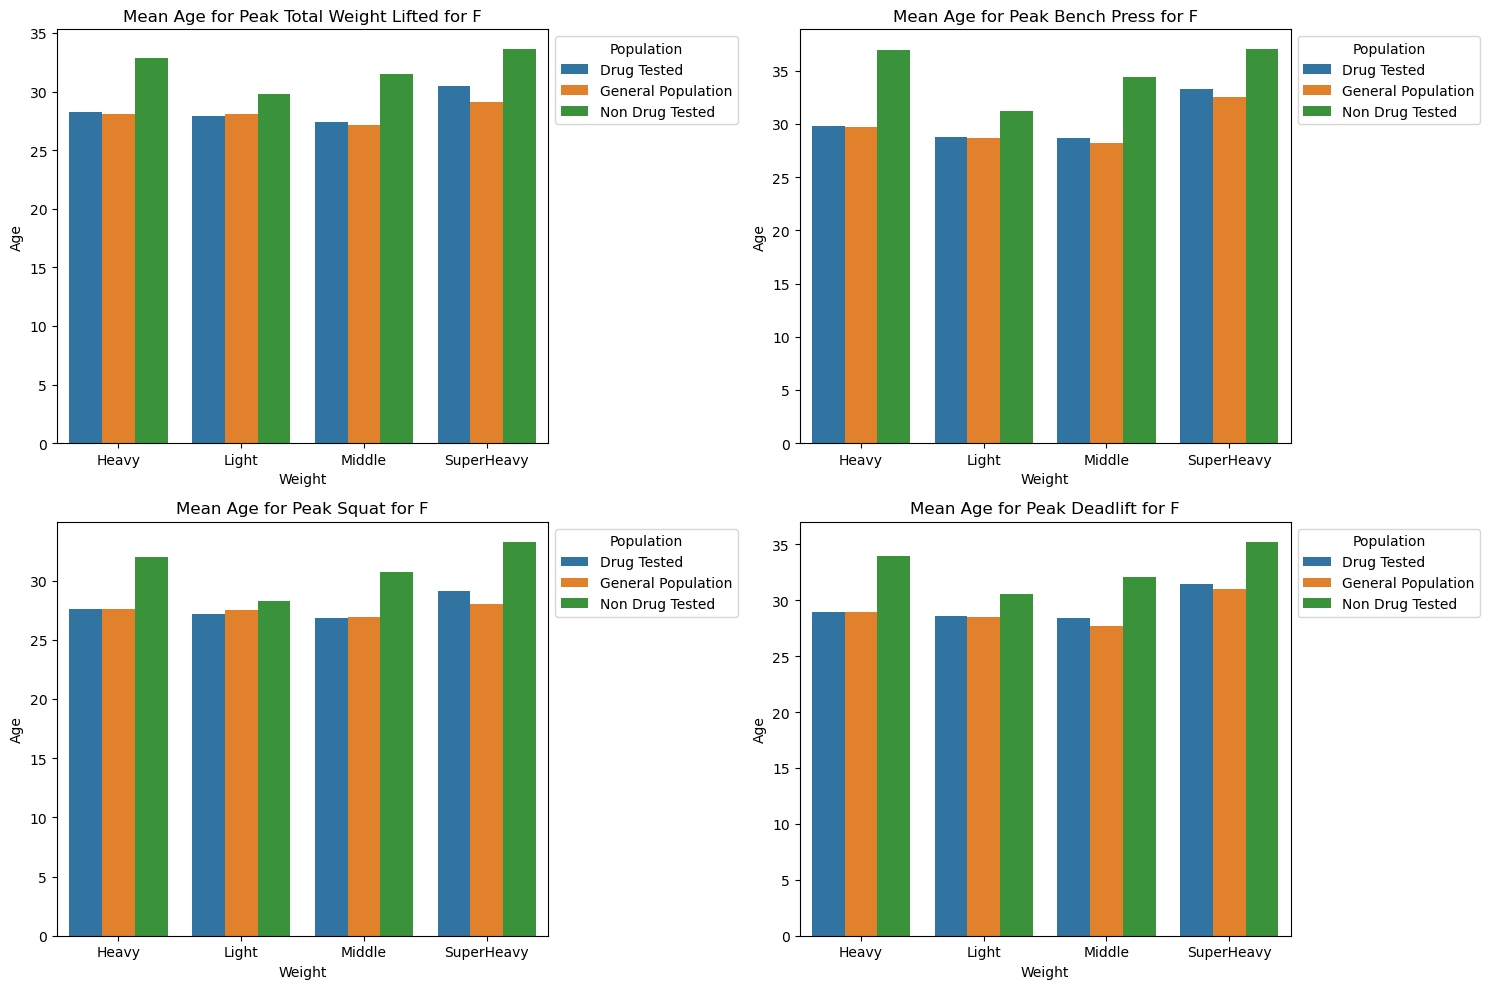

In [8]:
quad_plot_age(total, bench, squat, dead, 'F')

# Statistical Testing for Difference in Means

In [9]:
def mean_age_difference_z_test(total, sex, alpha):
    results = {}
    df = total.copy()
    weight_groups = df['Weight'].unique()
    for weight_group in weight_groups:
        pop_groups = df[df['Weight'] == weight_group]['Population'].unique()
        for i in range(len(pop_groups)):
            for j in range(i + 1, len(pop_groups)):
                population1 = pop_groups[i]
                population2 = pop_groups[j]
                
                sample1 = df[(df['Population'] == population1) & (df['Weight'] == weight_group) & (df['Sex'] == sex)]['Age']
                sample2 = df[(df['Population'] == population2) & (df['Weight'] == weight_group) & (df['Sex'] == sex)]['Age']
                z_stat, p_value = ztest(sample1, sample2)

                p_value_formatted = '{:.5f}'.format(p_value) 

                if p_value < alpha:
                    decision = 'Reject H0: There is a significant difference'
                else:
                    decision = 'Fail to reject H0: There is no significant difference'

                results[f'{weight_group} {population1} vs {population2}'] = {'Z statistic': z_stat,
                                                     'p-value': p_value_formatted,
                                                     'Decision': decision}
    print(df.groupby(['Weight','Population'])['Age'].describe())
    return results

In [10]:
mean_age_difference_z_test(total,'F',.05)

                                 count       mean       std   min   25%   50%  \
Weight     Population                                                           
Heavy      Drug Tested         14731.0  27.395153  6.813943  13.0  22.5  26.0   
           General Population   7568.0  27.581065  8.629202  14.5  21.5  25.5   
           Non Drug Tested      3947.0  30.470484  7.739327  15.0  25.0  29.0   
Light      Drug Tested          4170.0  26.747482  7.132112  14.5  21.5  25.0   
           General Population   2040.0  25.205392  8.947258  12.5  19.5  22.5   
           Non Drug Tested       506.0  27.675889  7.178950  15.0  23.0  26.0   
Middle     Drug Tested         12745.0  26.124637  6.306519  14.5  21.5  24.5   
           General Population   6677.0  25.557211  8.152408  14.0  20.5  23.0   
           Non Drug Tested      2416.0  28.914528  7.947149  15.0  23.0  27.0   
SuperHeavy Drug Tested          5515.0  29.329828  7.330054  14.5  23.5  28.0   
           General Populatio

{'Heavy Drug Tested vs Non Drug Tested': {'Z statistic': -20.006872572742733,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy Drug Tested vs General Population': {'Z statistic': 0.6469735695317702,
  'p-value': '0.51765',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Heavy Non Drug Tested vs General Population': {'Z statistic': 17.543560882250905,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light Drug Tested vs Non Drug Tested': {'Z statistic': -3.5198470613760953,
  'p-value': '0.00043',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light Drug Tested vs General Population': {'Z statistic': -0.4692177984550497,
  'p-value': '0.63891',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light Non Drug Tested vs General Population': {'Z statistic': 3.1415439731603647,
  'p-value': '0.00168',
  'Decision': 'Reject H0: There is a s

In [11]:
mean_age_difference_z_test(total,'M',.05)

                                 count       mean       std   min   25%   50%  \
Weight     Population                                                           
Heavy      Drug Tested         14731.0  27.395153  6.813943  13.0  22.5  26.0   
           General Population   7568.0  27.581065  8.629202  14.5  21.5  25.5   
           Non Drug Tested      3947.0  30.470484  7.739327  15.0  25.0  29.0   
Light      Drug Tested          4170.0  26.747482  7.132112  14.5  21.5  25.0   
           General Population   2040.0  25.205392  8.947258  12.5  19.5  22.5   
           Non Drug Tested       506.0  27.675889  7.178950  15.0  23.0  26.0   
Middle     Drug Tested         12745.0  26.124637  6.306519  14.5  21.5  24.5   
           General Population   6677.0  25.557211  8.152408  14.0  20.5  23.0   
           Non Drug Tested      2416.0  28.914528  7.947149  15.0  23.0  27.0   
SuperHeavy Drug Tested          5515.0  29.329828  7.330054  14.5  23.5  28.0   
           General Populatio

{'Heavy Drug Tested vs Non Drug Tested': {'Z statistic': -14.976106830959544,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy Drug Tested vs General Population': {'Z statistic': -3.824489276851223,
  'p-value': '0.00013',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy Non Drug Tested vs General Population': {'Z statistic': 8.131466326390179,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light Drug Tested vs Non Drug Tested': {'Z statistic': -0.22205814979234056,
  'p-value': '0.82427',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light Drug Tested vs General Population': {'Z statistic': 9.440518508432014,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light Non Drug Tested vs General Population': {'Z statistic': 4.545420908005381,
  'p-value': '0.00001',
  'Decision': 'Reject H0: There is a significant d